In [ ]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

2.6.0


In [ ]:
model = tf.keras.models.load_model('advcnn.h5')

In [ ]:
classes = ['background','person']

In [ ]:
import pickle
with open('sample_test_images.pickle', 'rb') as file:
    test_generator = pickle.load(file)

In [ ]:
test_images = test_generator[0][:50]
test_labels = test_generator[1][:50]

In [ ]:
test_lab2 = []
for lab in test_labels:
  test_lab2.append(lab[1])
test_lab2[0]

1.0

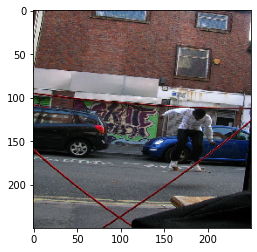

In [ ]:
plt.imshow(test_images[0])
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images[:50],  test_labels[:50], verbose=2)

print('\nTest accuracy:', test_acc)

2/2 - 1s - loss: 0.6063 - accuracy: 0.7000

Test accuracy: 0.699999988079071


In [ ]:
predictions = model.predict(test_images)
predictions[:10]

array([[0.5082496 , 0.49747455],
       [0.46585143, 0.53193855],
       [0.46638766, 0.5406001 ],
       [0.5175692 , 0.46261394],
       [0.64220923, 0.3269487 ],
       [0.4017613 , 0.589558  ],
       [0.5642845 , 0.4375508 ],
       [0.4371271 , 0.5400719 ],
       [0.5110427 , 0.48414475],
       [0.57794565, 0.39589798]], dtype=float32)

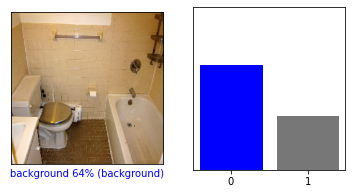

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[i], cmap=plt.cm.binary)
    if predictions_array[0] > predictions_array[1]:
        pred = 0
    else: pred = 1
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    if pred == act:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(classes[pred],
                                100*np.max(predictions_array),
                                classes[act]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predictions_array[0] > predictions_array[1]:
        pred = 0
    else: pred = 1
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    thisplot[pred].set_color('red')
    thisplot[act].set_color('blue')

i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

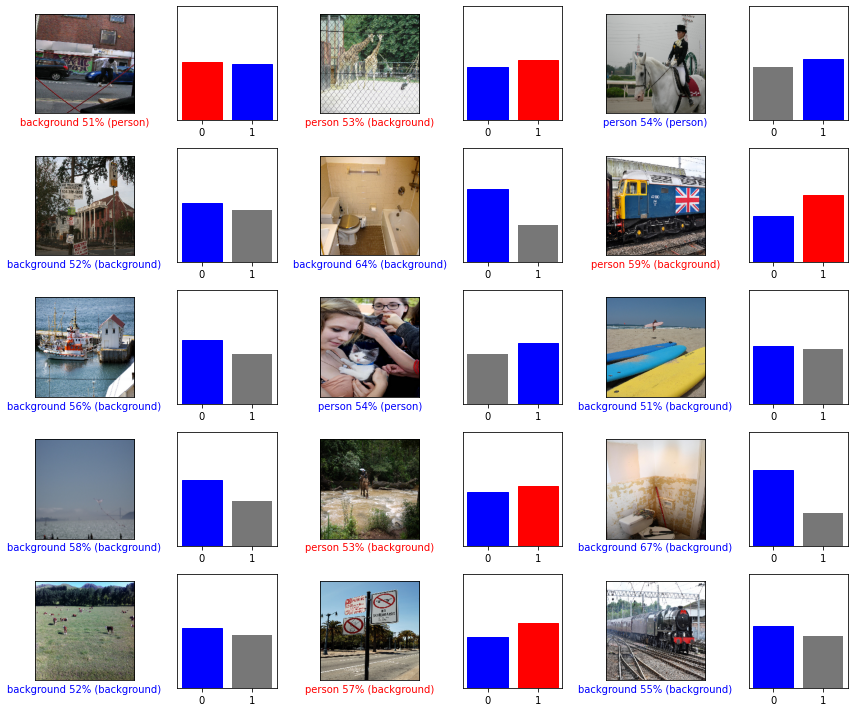

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

(250, 250, 3)
(1, 250, 250, 3)
[[0.46585146 0.53193855]]


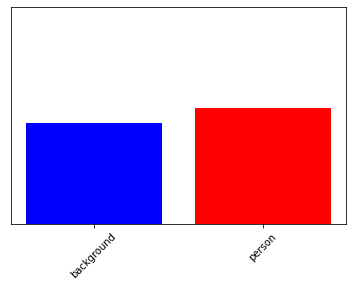

In [ ]:
img = test_images[1]
print(img.shape)
img = (np.expand_dims(img,0))
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(2), classes, rotation=45)
plt.show()

Model Convertion to TensorFlow Lite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpg1mup8by/assets


INFO:tensorflow:Assets written to: /tmp/tmpg1mup8by/assets


In [ ]:
open("v1.tflite", "wb").write(tflite_model)

110335868

In [ ]:
import math
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [ ]:
size = os.path.getsize('v1.tflite')

In [ ]:
convert_size(size)

'105.22 MB'

reduced 1 third of the size but still large as TensorFlow lite model still using 32-bit float values and all the parameters. 

now enabled the default optimizations flag to quantize all fixed parramters such as weights

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpffckyi9u/assets


INFO:tensorflow:Assets written to: /tmp/tmpffckyi9u/assets


In [ ]:
open("v1_con.tflite", "wb").write(tflite_model_quant)

27592336

In [ ]:
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('v1_con.tflite'))))

size after quanized. is 26.31 MB bytes


This is a significant reduction. but weigts are still in float format

converting using float fall back quantization

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(30):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp_xz3_2l1/assets


INFO:tensorflow:Assets written to: /tmp/tmp_xz3_2l1/assets


In [ ]:
open("v1_con2.tflite", "wb").write(tflite_model_quant)

27592336

In [ ]:
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('v1_con2.tflite'))))

size after quanized. is 26.31 MB bytes


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(30):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmprbgloefq/assets


INFO:tensorflow:Assets written to: /tmp/tmprbgloefq/assets


In [ ]:
open("v1_con3.tflite", "wb").write(tflite_model_quant)
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('v1_con3.tflite'))))

size after quanized. is 26.31 MB bytes


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


save lite model as files

In [ ]:
import pathlib

In [ ]:
tflite_models_dir = pathlib.Path("/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

110335868

In [ ]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

27592432

Running TensorFlow Lite Models

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


In [ ]:
# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

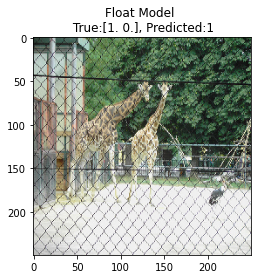

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="Float")

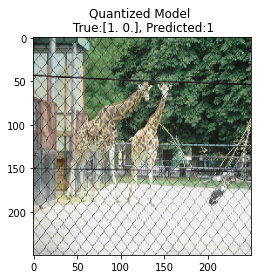

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_lab2

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_lab2== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 70.0000% (Number of test samples=50)


In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

Quantized model accuracy is 70.0000% (Number of test samples=50)


In [ ]:
test_image_index = 1
test_image_indices = range(test_images.shape[0])
predictions = run_tflite_model(tflite_model_quant_file, test_image_indices)
predictions

array([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1])

In [ ]:
tflite_file = tflite_model_quant_file
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
interpreter.allocate_tensors()

In [ ]:
interpreter

In [ ]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [ ]:
input_details

{'dtype': numpy.uint8,
 'index': 0,
 'name': 'conv2d_6_input',
 'quantization': (0.003921568859368563, 0),
 'quantization_parameters': {'quantized_dimension': 0,
  'scales': array([0.00392157], dtype=float32),
  'zero_points': array([0], dtype=int32)},
 'shape': array([  1, 250, 250,   3], dtype=int32),
 'shape_signature': array([ -1, 250, 250,   3], dtype=int32),
 'sparsity_parameters': {}}

In [ ]:
output_details

{'dtype': numpy.uint8,
 'index': 23,
 'name': 'Identity',
 'quantization': (0.00390625, 0),
 'quantization_parameters': {'quantized_dimension': 0,
  'scales': array([0.00390625], dtype=float32),
  'zero_points': array([0], dtype=int32)},
 'shape': array([1, 2], dtype=int32),
 'shape_signature': array([-1,  2], dtype=int32),
 'sparsity_parameters': {}}

In [ ]:
test_image_indices = range(test_images.shape[0])
test_image_indices

range(0, 50)

In [ ]:
np.zeros((len(test_image_indices),), dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details["index"])[0]
    print(output.argmax())



0
1
1
0
0
1
0
1
0
0
1
0
0
1
0
0
1
0
0
0
1
1
1
1
1
0
0
1
1
0
0
1
0
0
0
1
1
1
0
0
1
0
0
0
0
0
1
1
1
1


In [ ]:
test_image.shape, test_label.shape, input_scale, input_zero_point

((1, 250, 250, 3), (2,), 0.003921568859368563, 0)

In [ ]:
print(test_label[1])
print(test_labels[2])

0.0
[0. 1.]


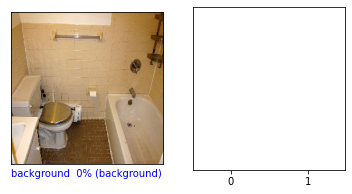

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[i], cmap=plt.cm.binary)
    # if predictions_array[0] > predictions_array[1]:
        # pred = 0
    # else: pred = 1
    pred = predictions_array
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    if pred == act:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(classes[pred],
                                100*np.max(predictions_array),
                                classes[act]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    # if predictions_array[0] > predictions_array[1]:
    #     pred = 0
    # else: pred = 1
    pred = predictions_array
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    thisplot[pred].set_color('red')
    thisplot[act].set_color('blue')

i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

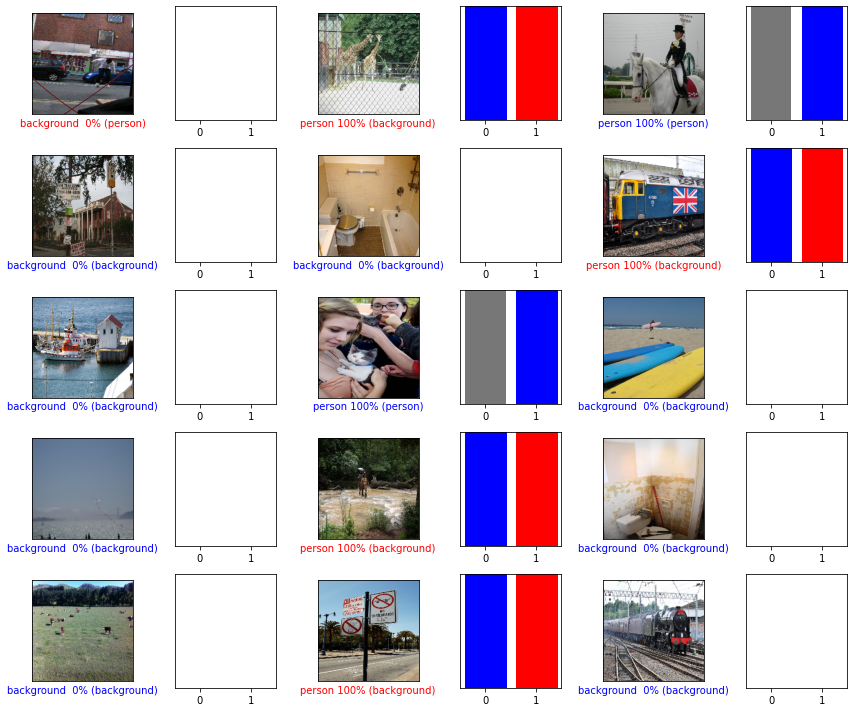

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()